In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import Preprocess_gokhanEr as pp

In [3]:
path = "/Users/gokhanersoz/Desktop/Hepsi/NLP/Data/imdb_reviews.txt"

In [4]:
df = pd.read_csv(path, header = None,sep = "\t")
df.columns = ["Reviews","Sentiment"]
df.head()

,Reviews,Sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [5]:
df["Reviews"] = df["Reviews"].apply(lambda words : pp.cont_exp(words))
df["Reviews"] = df["Reviews"].apply(lambda words : pp.remove_special_chars(words))
df["Reviews"] = df["Reviews"].apply(lambda words : pp.remove_accented_chars(words))
df["Reviews"] = df["Reviews"].apply(lambda words : pp.remove_emails(words))
df["Reviews"] = df["Reviews"].apply(lambda words : pp.remove_html_tags(words))
df["Reviews"] = df["Reviews"].apply(lambda words : pp.remove_urls(words))
df["Reviews"] = df["Reviews"].apply(lambda words : pp.get_make_base(words))
df["Reviews"] = df["Reviews"].apply(lambda words : pp.spelling_correction(words))
df["Reviews"] = df["Reviews"].apply(lambda words : pp.get_lower_convert(words))

In [6]:
df.head()

,Reviews,Sentiment
0,a very very very slowmove aimless movie about ...,0
1,not sure who was more lose the flat character ...,0
2,attempt artless with black white and clever ca...,0
3,very little music or anything to speak of,0
4,the good scene in the movie was when gerard is...,1


## Data Preparation For Model Training

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn.metrics import accuracy_score,r2_score,precision_score,recall_score,roc_auc_score, \
                            classification_report,confusion_matrix,roc_curve

In [8]:
X = df["Reviews"]
y = df["Sentiment"]

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X, y , 
                                                random_state = 0 ,test_size = 0.2, stratify = y)

In [10]:
print("X Train Shape : {}".format(X_train.shape))
print()
print("X Test Shape : {}".format(X_test.shape))

X Train Shape : (598,)

X Test Shape : (150,)


## ML Model Building

In [11]:
pipe = Pipeline([
       ("tfidf", TfidfVectorizer()),
       ("clf", LogisticRegression(solver = "liblinear"))
       ])

In [12]:
hyperparamaters = {
    
    "vector__max_df" : (0.5,1.0),
    "vector__ngram_range" : ((1,1),(1,2)),
    "vector__use_idf" : (True,False),
    "vector__analyzer" : ("word","char","char_wb"),
    "clf__penalty" : ("l2","l1"),
    "clf__C": (1,2)
}

In [13]:
def nlp_tuning(vectorizer , classification, hyperparamaters , X, y, score = "accuracy", cv = None):
    
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    
    pipe = Pipeline([
        ("vector" , vectorizer),
        ("clf", classification)
    ])
    
    
    best_grid = GridSearchCV(estimator=pipe,
                             param_grid=hyperparamaters,
                             n_jobs=-1,
                             verbose = 0,
                             cv = cv,
                             scoring=score).fit(X, y)
 
    print(f' {type(classification).__name__.upper()} '.center(50,"#"))
    print()
    print("Best Params :\n\n {}".format(best_grid.best_params_))
    print()
    print("Best Estimator :\n\n {}".format(best_grid.best_estimator_))
    print()
    print("Score :\n\n {}".format(best_grid.best_score_))
    
    return best_grid

In [14]:
grid_svc = nlp_tuning(TfidfVectorizer(), LinearSVC(), hyperparamaters, X_train, y_train)

################### LINEARSVC ####################

Best Params :

 {'clf__C': 1, 'clf__penalty': 'l2', 'vector__analyzer': 'word', 'vector__max_df': 1.0, 'vector__ngram_range': (1, 1), 'vector__use_idf': True}

Best Estimator :

 Pipeline(steps=[('vector', TfidfVectorizer()), ('clf', LinearSVC(C=1))])

Score :

 0.7858963585434173


In [15]:
grid_logistic = nlp_tuning(TfidfVectorizer(), LogisticRegression(solver = "liblinear"), hyperparamaters,
                           X_train, y_train)

############### LOGISTICREGRESSION ###############

Best Params :

 {'clf__C': 2, 'clf__penalty': 'l2', 'vector__analyzer': 'word', 'vector__max_df': 0.5, 'vector__ngram_range': (1, 1), 'vector__use_idf': True}

Best Estimator :

 Pipeline(steps=[('vector', TfidfVectorizer(max_df=0.5)),
                ('clf', LogisticRegression(C=2, solver='liblinear'))])

Score :

 0.779187675070028


In [16]:
y_pred_logistic = grid_logistic.predict(X_test)
y_pred_svc = grid_svc.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.74      0.73      0.73        73
           1       0.74      0.75      0.75        77

    accuracy                           0.74       150
   macro avg       0.74      0.74      0.74       150
weighted avg       0.74      0.74      0.74       150



In [18]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73        73
           1       0.75      0.70      0.72        77

    accuracy                           0.73       150
   macro avg       0.73      0.73      0.73       150
weighted avg       0.73      0.73      0.73       150



In [19]:
fpr_logistic,tpr_logistic,threshold_logistic = roc_curve(y_test, grid_logistic.predict_proba(X_test)[:,1])

In [20]:
def roc_graph(X,y,Classification):
    
    fpr,tpr,threshold= roc_curve(y, Classification.predict_proba(X)[:,1])

    y_pred = Classification.predict(X)
    roc_score = roc_auc_score(y,y_pred)

    plt.figure(figsize = (15,8))
    plt.plot(fpr_logistic,tpr_logistic, color = "green")
    plt.plot([0,1],[0,1], color = "black")
    
    name = type(Classification.best_estimator_[1]).__name__
    
    size = 15
    plt.title(f"Roc Auc For {name.upper()}\n\n Roc Auc Score :{ roc_score}", 
              fontsize = size)
    plt.ylabel("True Positive Rate", fontsize = size)
    plt.xlabel("False Positive Rate", fontsize = size)
    plt.show()

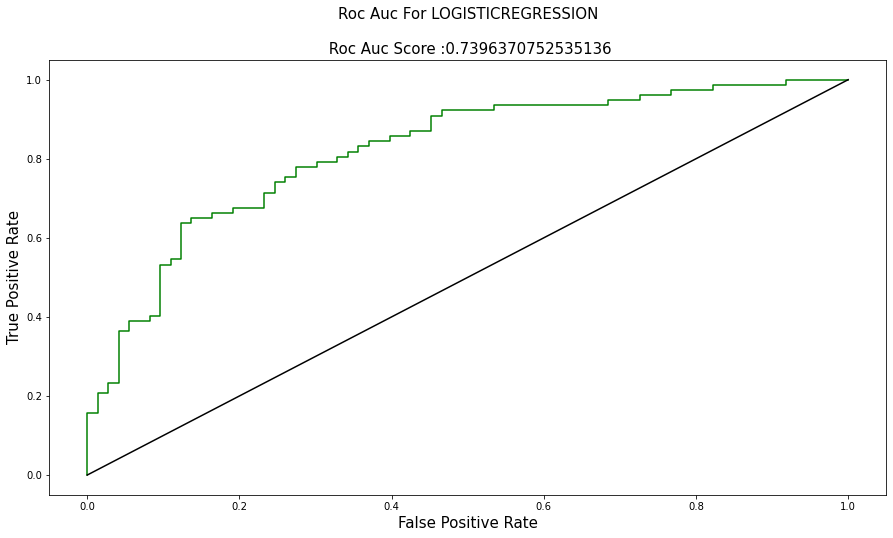

In [21]:
roc_graph(X_test, y_test, grid_logistic)

In [22]:
def confusion_graph(X, y , Classification):
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    y_pred = Classification.predict(X)
    

    cm = confusion_matrix(y, y_pred)
    
    name = type(Classification.best_estimator_[1]).__name__
    
    plt.figure(figsize = (12,7))
    
    
    sns.heatmap(cm, annot = True,cbar = False, cmap = "viridis", annot_kws = {"size" : 15},
                fmt = "d",linecolor="white",linewidths=0.2)
    
    size = 15
    plt.title(f"Confusion Graph For {name.upper()}", size = size)
    plt.ylabel("Actual",size = size)
    plt.xlabel("Predicted",size = size)
    plt.show()

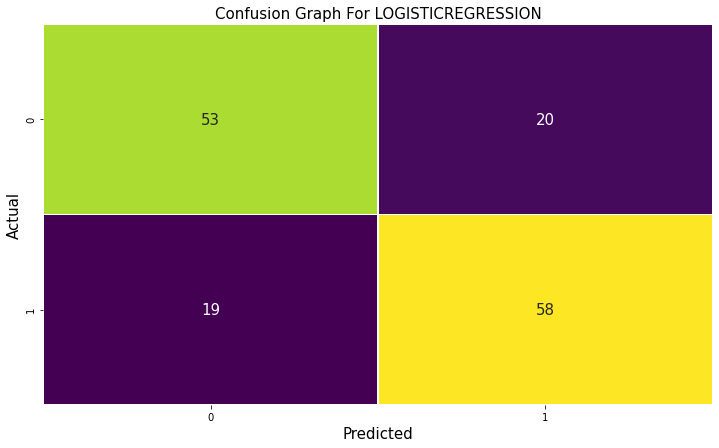

In [23]:
confusion_graph(X_test ,y_test , grid_logistic)

## Model Saving 

In [24]:
import pickle

In [25]:
x = ["this is great moview. i loved it","i have watched this movie. plot is straight."]

In [29]:
pickle.dump(grid_logistic, open("grid_logistic.pkl","wb"))

clf = pickle.load(open("grid_logistic.pkl","rb"))
clf.predict(x)

array([1, 0])